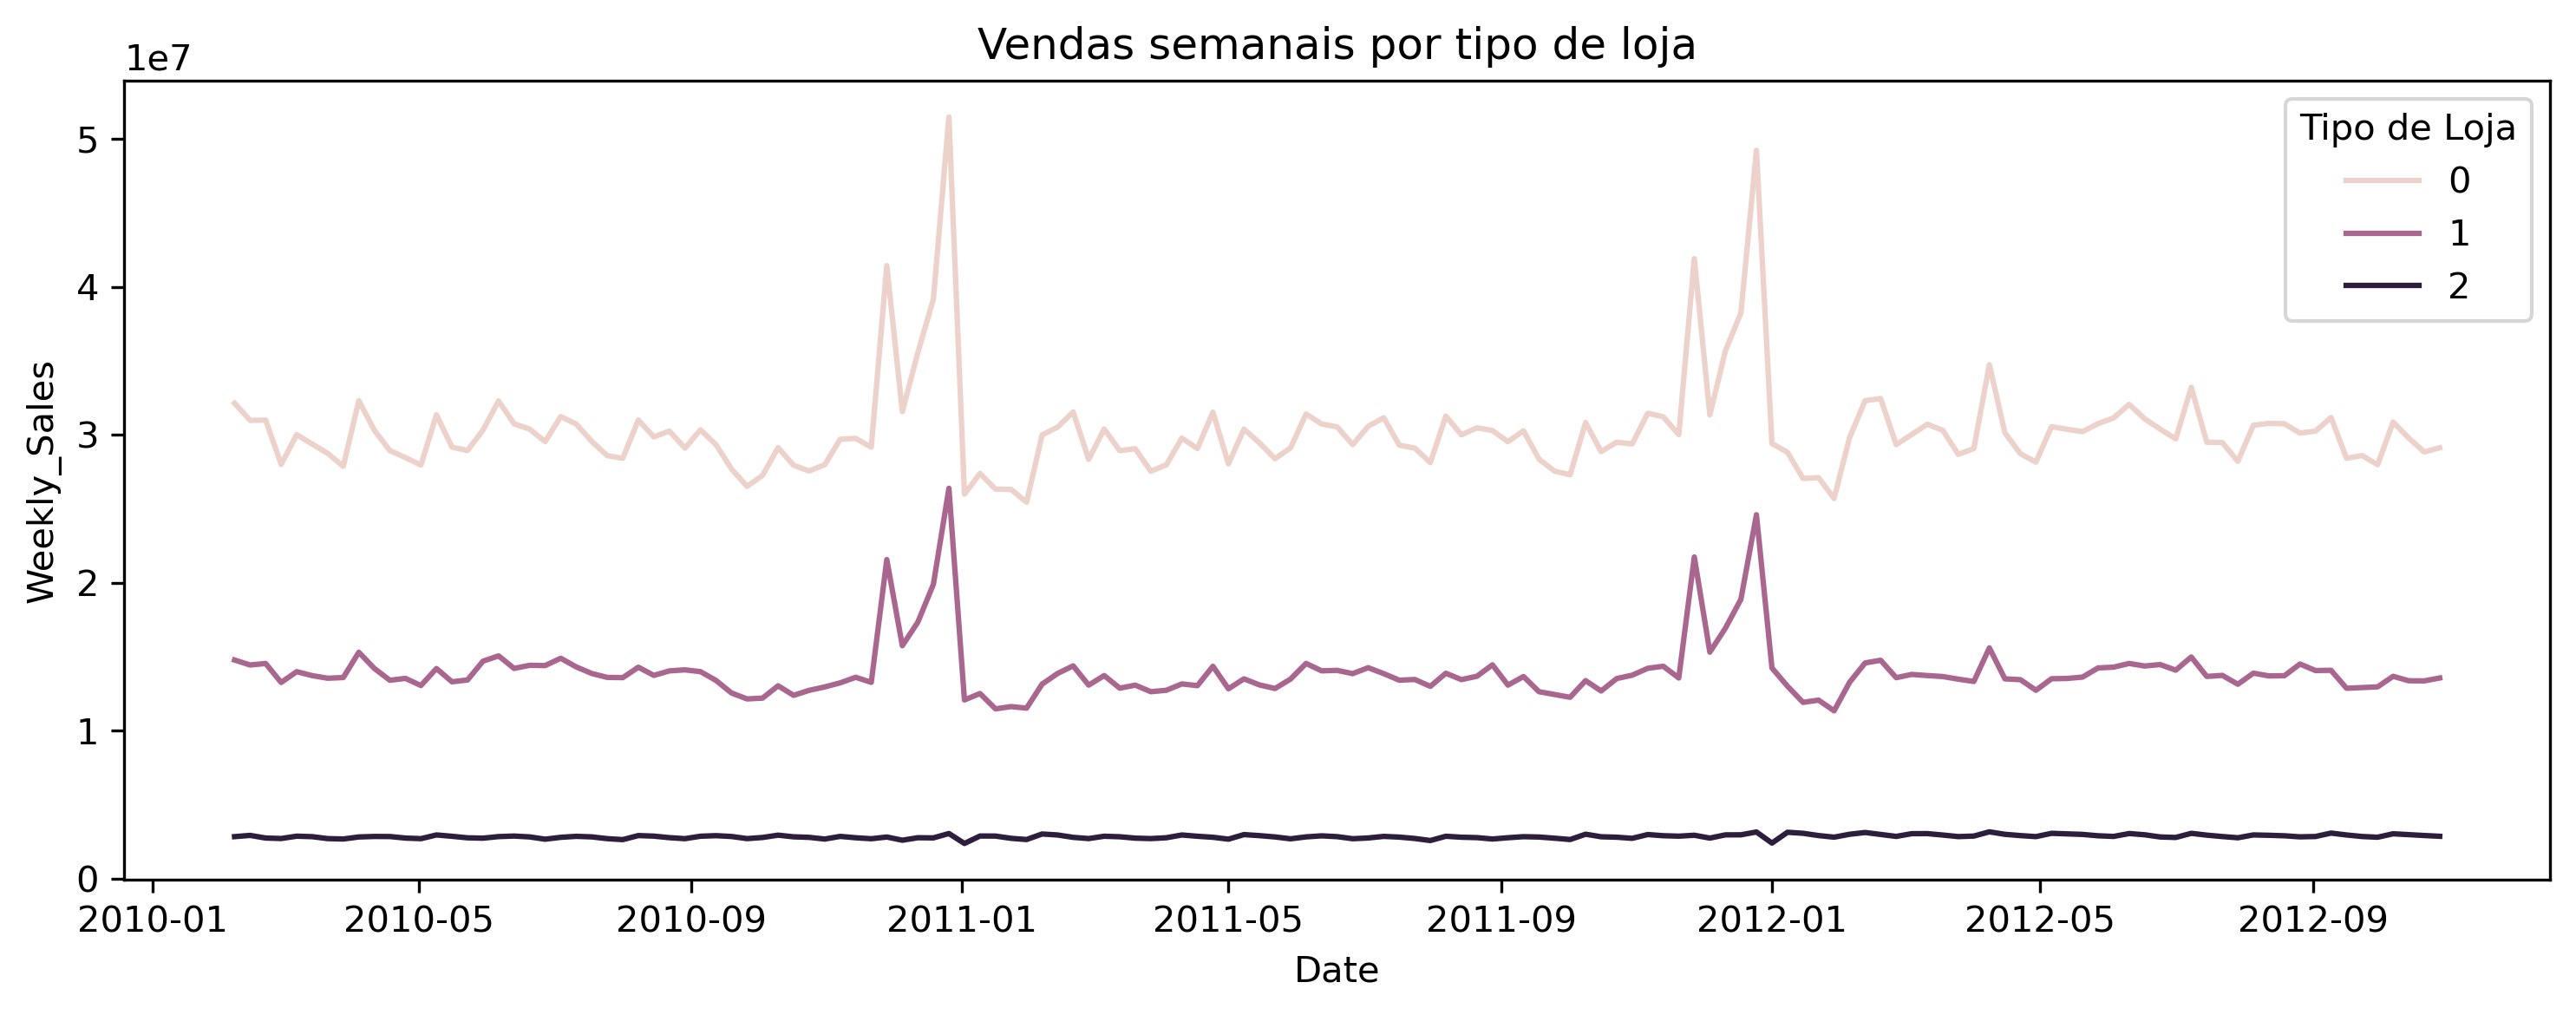

In [124]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Bibliotecas
--------------------------------------------------------------------------------------------------------------------
'''

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from warnings import filterwarnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/WalmartSalesForecast/Arquivos CSV")

'''
--------------------------------------------------------------------------------------------------------------------
-------- Importando e editando o dataframe
--------------------------------------------------------------------------------------------------------------------
'''

train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')

# Editando o df de treino

# Eliminando, pois essa coluna já existe em treino e teste
features = features.drop(columns='IsHoliday')

# Juntando as colunas de features dos arquivos Stores e Features
train_merge = pd.merge(train, stores, on='Store', how='left')
train_merge = pd.merge(train_merge, features, on=['Store', 'Date'], how='left')

# Editando o df
train_merge = train_merge.set_index('Date')
train_merge.index = pd.to_datetime(train_merge.index)

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(train_merge['Type'].unique()):
    transf[valor] = i

train_merge['Type'] = train_merge['Type'].map(transf)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Timeline
--------------------------------------------------------------------------------------------------------------------
'''

sales_by_type_weekly = train_merge.groupby('Type').resample('W')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(10, 4), dpi=300)
sns.lineplot(data=sales_by_type_weekly, x='Date', y='Weekly_Sales', hue='Type')
plt.title('Vendas semanais por tipo de loja')
plt.legend(title='Tipo de Loja')
plt.tight_layout()
plt.show()

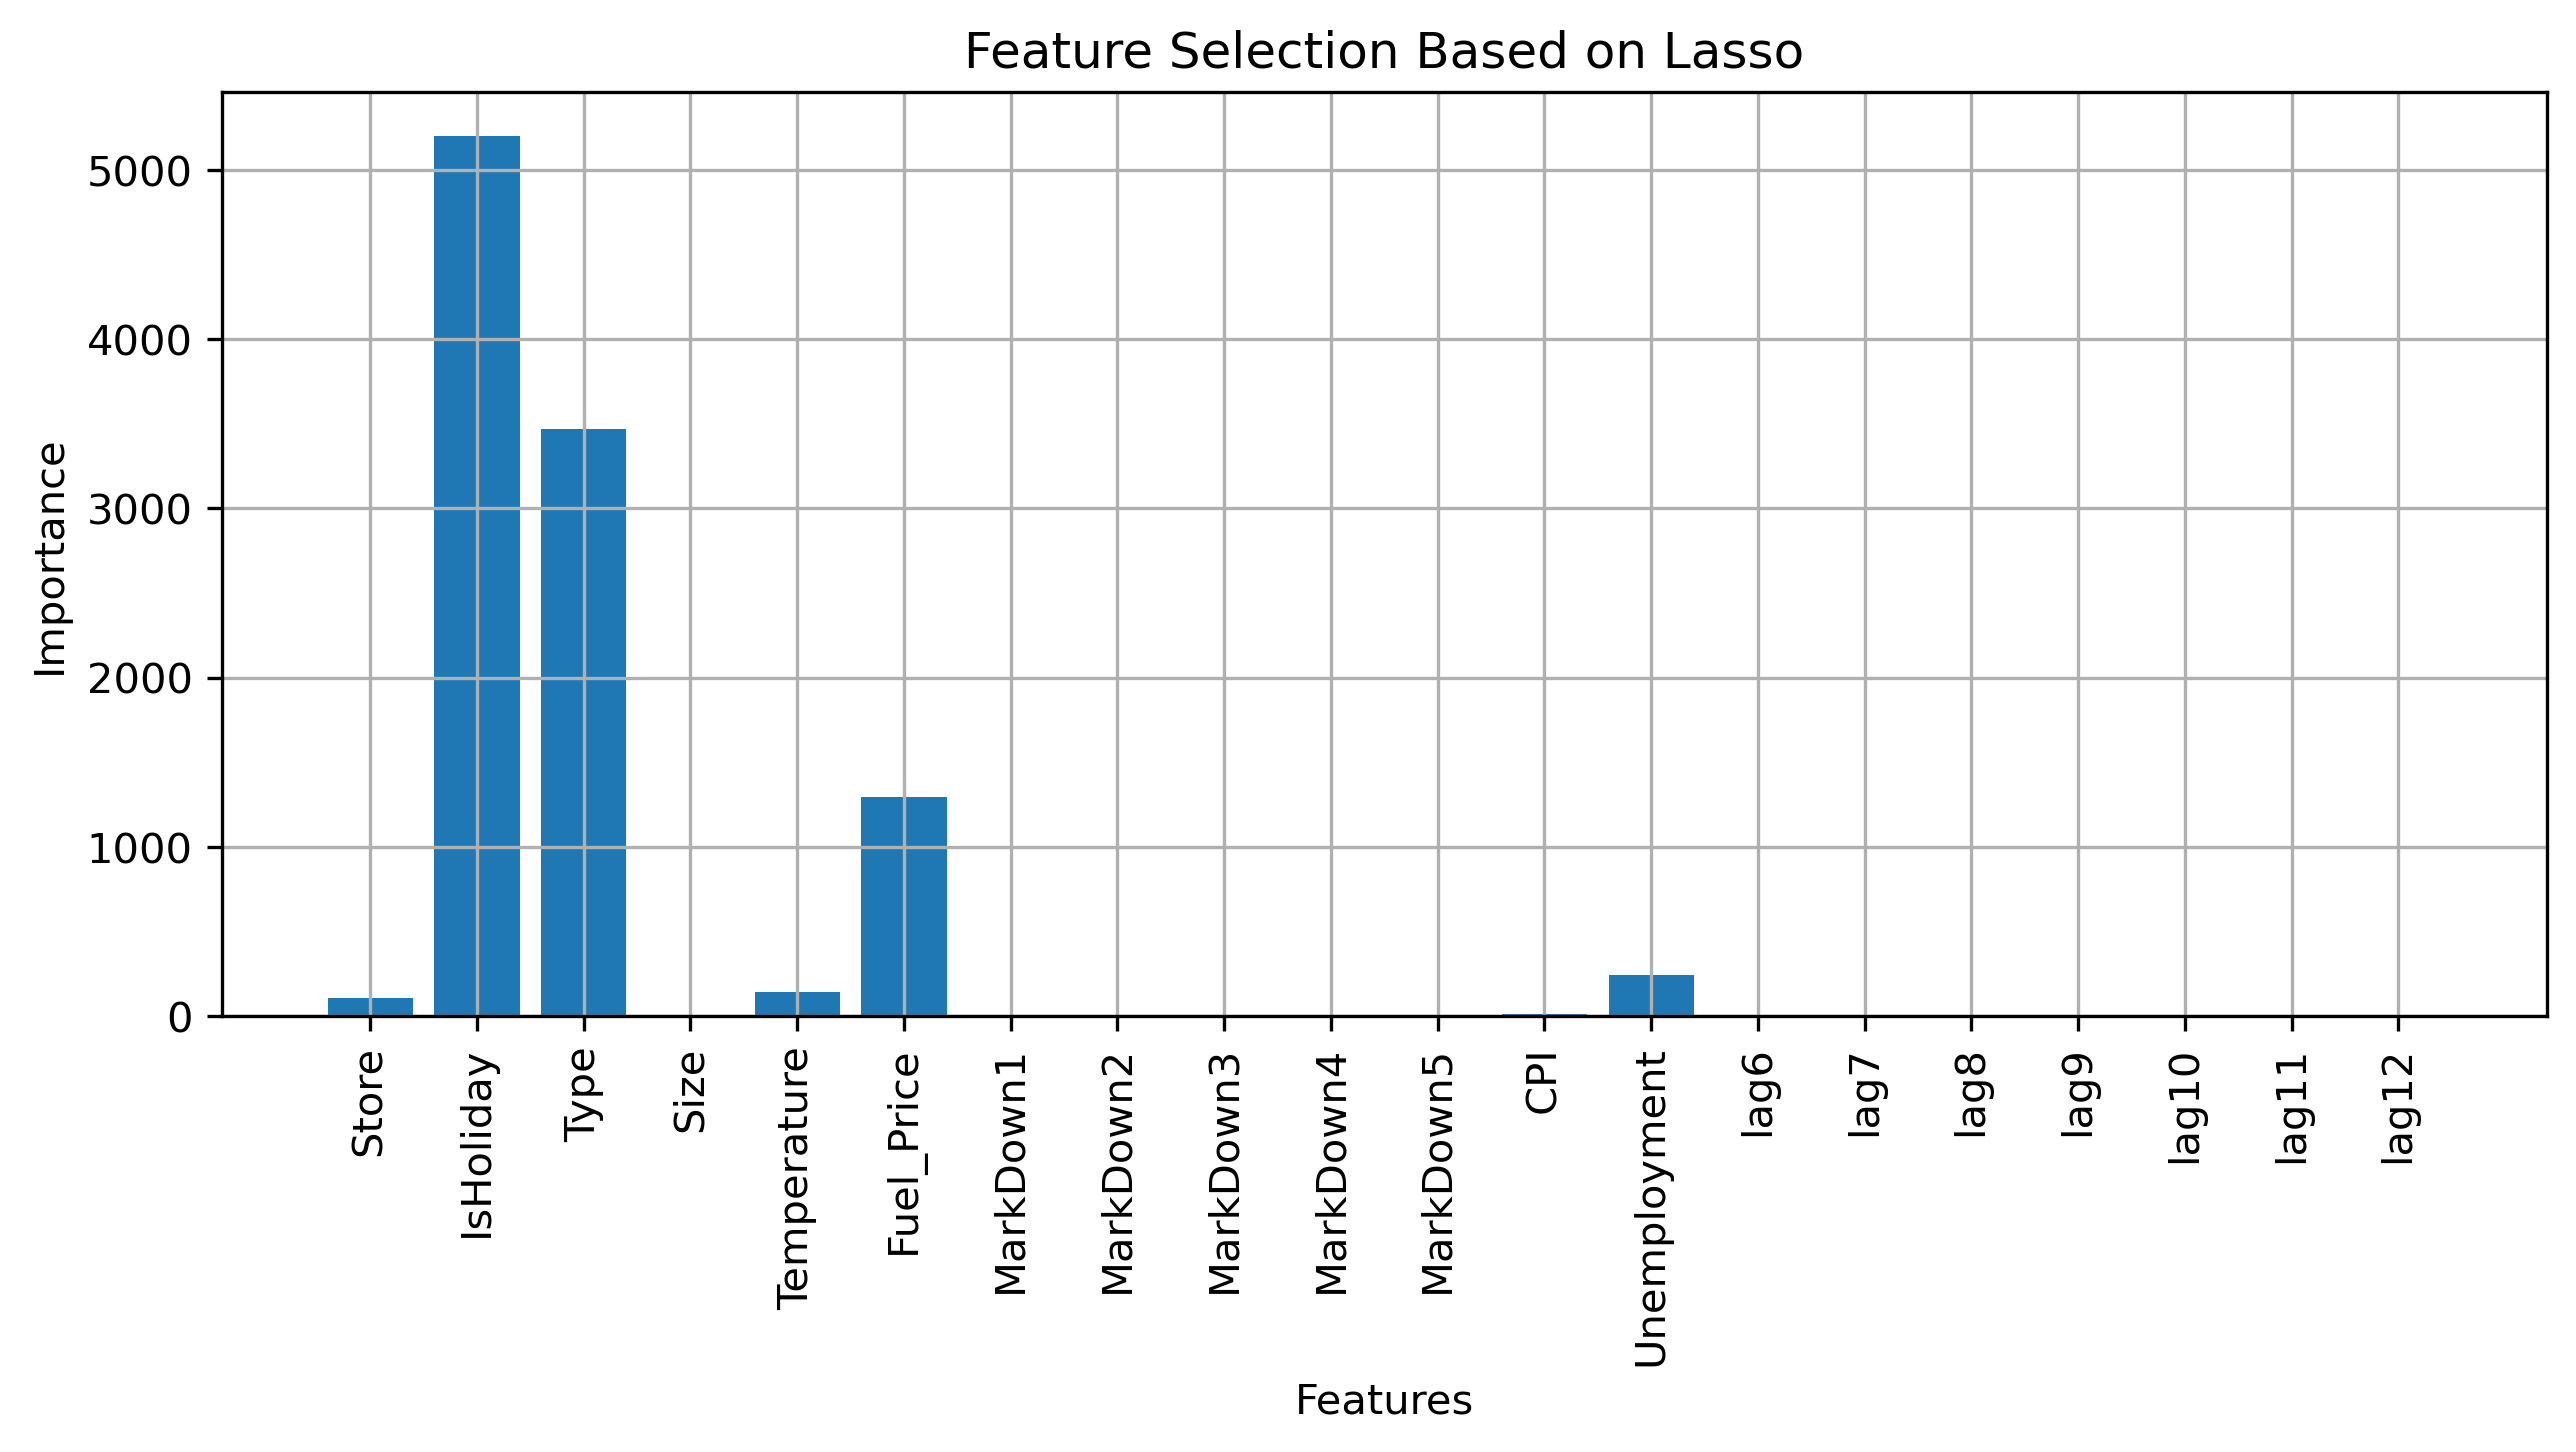

In [125]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Separando dataset por departamento
--------------------------------------------------------------------------------------------------------------------
'''

dept1 = train_merge[train_merge['Dept'] == 1]
dept1 = dept1.drop(columns='Dept')

'''
--------------------------------------------------------------------------------------------------------------------
-------- Gerando Lags
-------- Começando do lag 6 pq quero prever 6 semanas no futuro
--------------------------------------------------------------------------------------------------------------------
'''

for i in range(6, 13):
    dept1[f'lag{i}'] = dept1.groupby('Store')['Weekly_Sales'].shift(i)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Analisando feature importance
--------------------------------------------------------------------------------------------------------------------
'''

dept1_dropna = dept1.dropna()

# Separando as features do target
X = dept1_dropna.drop(columns='Weekly_Sales') 
y = dept1_dropna['Weekly_Sales']

col_names = X.columns

from sklearn.linear_model import Lasso

# Lasso
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

lasso = Lasso(alpha=0.00001)
lasso.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso_coef = np.abs(lasso.coef_)

# plotting the Column Names and Importance of Columns. 
plt.figure(figsize=(10, 4), dpi=300)
plt.bar(col_names, lasso_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Filtrando as features com coeficiente maior que 0.01
filtered_columns = [name for name, coef in zip(col_names, lasso_coef) if coef > 0.01]
colunas = filtered_columns

In [126]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Separando colunas definidas pelo Lasso para criar Treino e Teste
--------------------------------------------------------------------------------------------------------------------
'''

colunas = ['Weekly_Sales', 'Store', 'IsHoliday', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11']

dept1 = dept1[colunas]
dept1 = dept1.dropna()

X = dept1.drop(columns='Weekly_Sales')
y = dept1['Weekly_Sales']

X_train = X[X.index < '2012-09-21']
y_train = y[y.index < '2012-09-21']
X_test = X[X.index >= '2012-09-21']
y_test = y[y.index >= '2012-09-21']

# Validando o corte das datas cima
if X_train.index.min() == y_train.index.min() and X_train.index.max() == y_train.index.max():
    print("Treino: ", X_train.index.min(), "|", X_train.index.max())
else:
    print("Verificar datas do treino")

if X_test.index.min() == y_test.index.min() and X_test.index.max() == y_test.index.max():
    print("Teste : ", X_test.index.min(), "|", X_test.index.max())
else:
    print("Verificar datas do teste")

Treino:  2011-11-11 00:00:00 | 2012-09-14 00:00:00
Teste :  2012-09-21 00:00:00 | 2012-10-26 00:00:00


In [127]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- XGBRegressor default
--------------------------------------------------------------------------------------------------------------------
'''

model = xgb.XGBRegressor(verbosity=1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [128]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Comparação dos valores reais X valores preditos 
--------------------------------------------------------------------------------------------------------------------
'''

predictions = model.predict(X_test)

df_resultados = pd.DataFrame({'Data': X_test.index, 'Valor_Real': y_test, 'Valor_Predito': predictions})
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.drop(columns=['Date'])
df_resultados['Data'] = pd.to_datetime(df_resultados['Data'])

df_resultados = df_resultados.groupby('Data')[['Valor_Real', 'Valor_Predito']].sum().reset_index()
df_resultados['Valor_Predito'] = df_resultados['Valor_Predito'].round(decimals=2)

df_resultados.sort_values(by='Data', inplace=True)

df_resultados.head()


,Data,Valor_Real,Valor_Predito
0,2012-09-21,613677.46,562810.18750
1,2012-09-28,597394.25,532080.50000
2,2012-10-26,924139.79,497243.90625


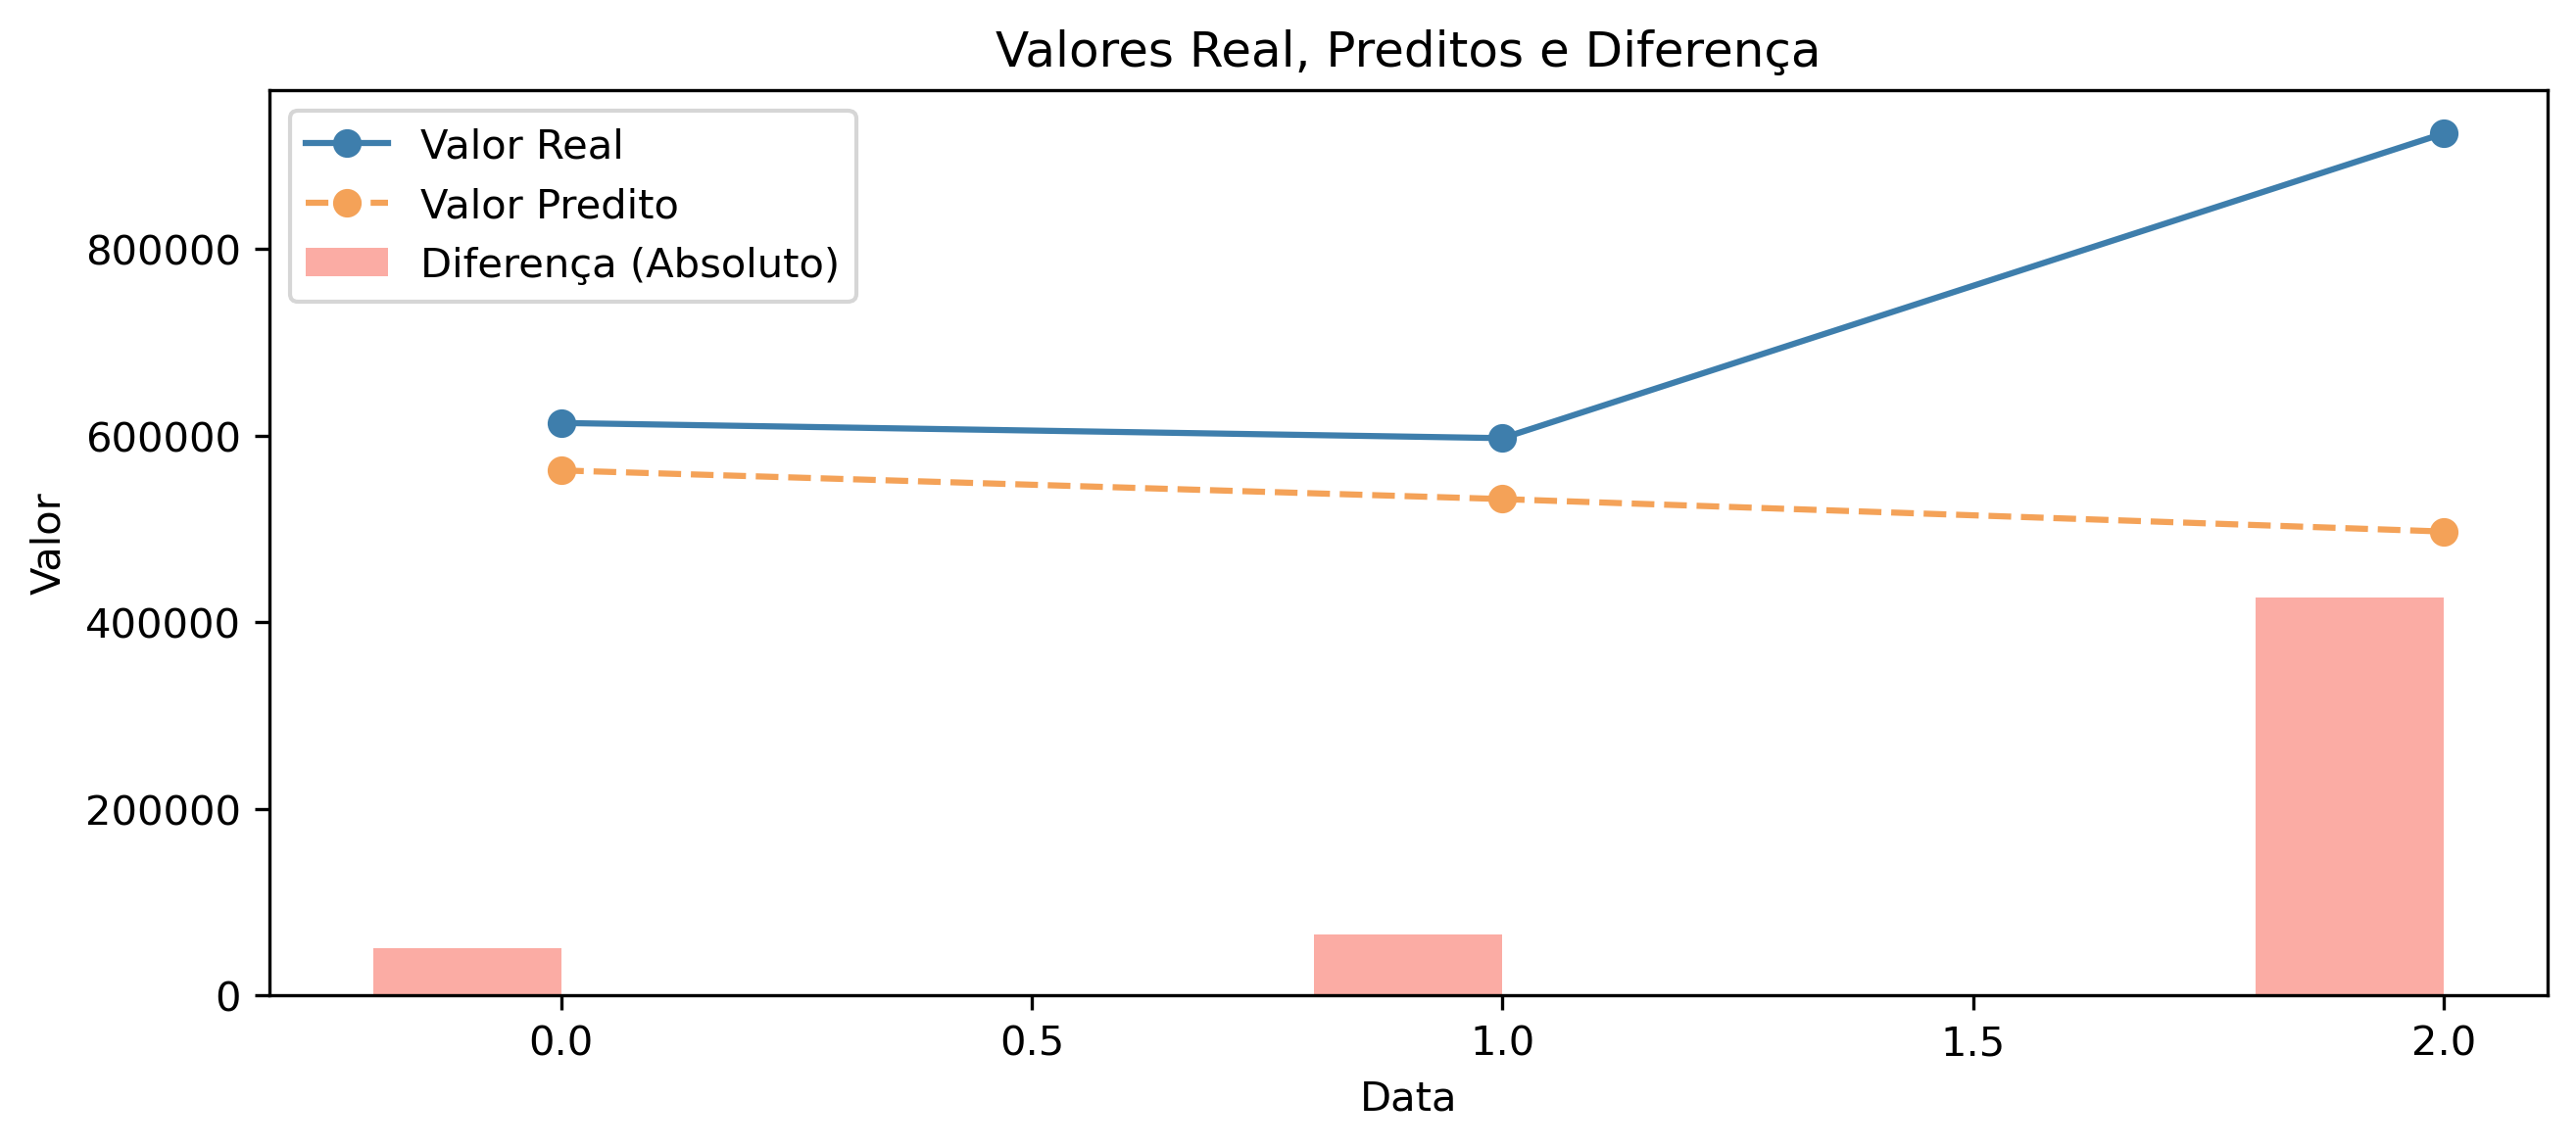

In [129]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Gráfico com os valores reais e preditos nas linhas + valores de erro nas barras
--------------------------------------------------------------------------------------------------------------------
'''

# Coluna de diferença
df_resultados['Diferenca'] = df_resultados['Valor_Real'] - df_resultados['Valor_Predito']

plt.figure(figsize=(10, 4), dpi=300)
plt.plot(df_resultados.index, df_resultados['Valor_Real'], color='#3e7eac', label='Valor Real', marker='o')
plt.plot(df_resultados.index, df_resultados['Valor_Predito'], color='#f4a258', label='Valor Predito', marker='o', linestyle='--')

bar_width = 0.2
plt.bar(df_resultados.index - bar_width/2, df_resultados['Diferenca'].abs(), color='#fbaca4', label='Diferença (Absoluto)', width=bar_width)

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Real, Preditos e Diferença')
plt.legend()
plt.show()

In [130]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Erros
--------------------------------------------------------------------------------------------------------------------
'''
error = np.sum(predictions - y_test).round(2)

rmse = mean_squared_error(y_test, predictions, squared=False)

mae = mean_absolute_error(y_test, predictions)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.DataFrame({'Teste': ['XGBRegressor Default'],
                           'Erro Total': [error],
                           'RMSE': [rmse],
                           'MAE': [mae],
                           'MAPE (%)': [mape]
                            })


# Exibir o DataFrame
results_df.head()

,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default,-543076.87,10255.4159,6402.467963,21.751738


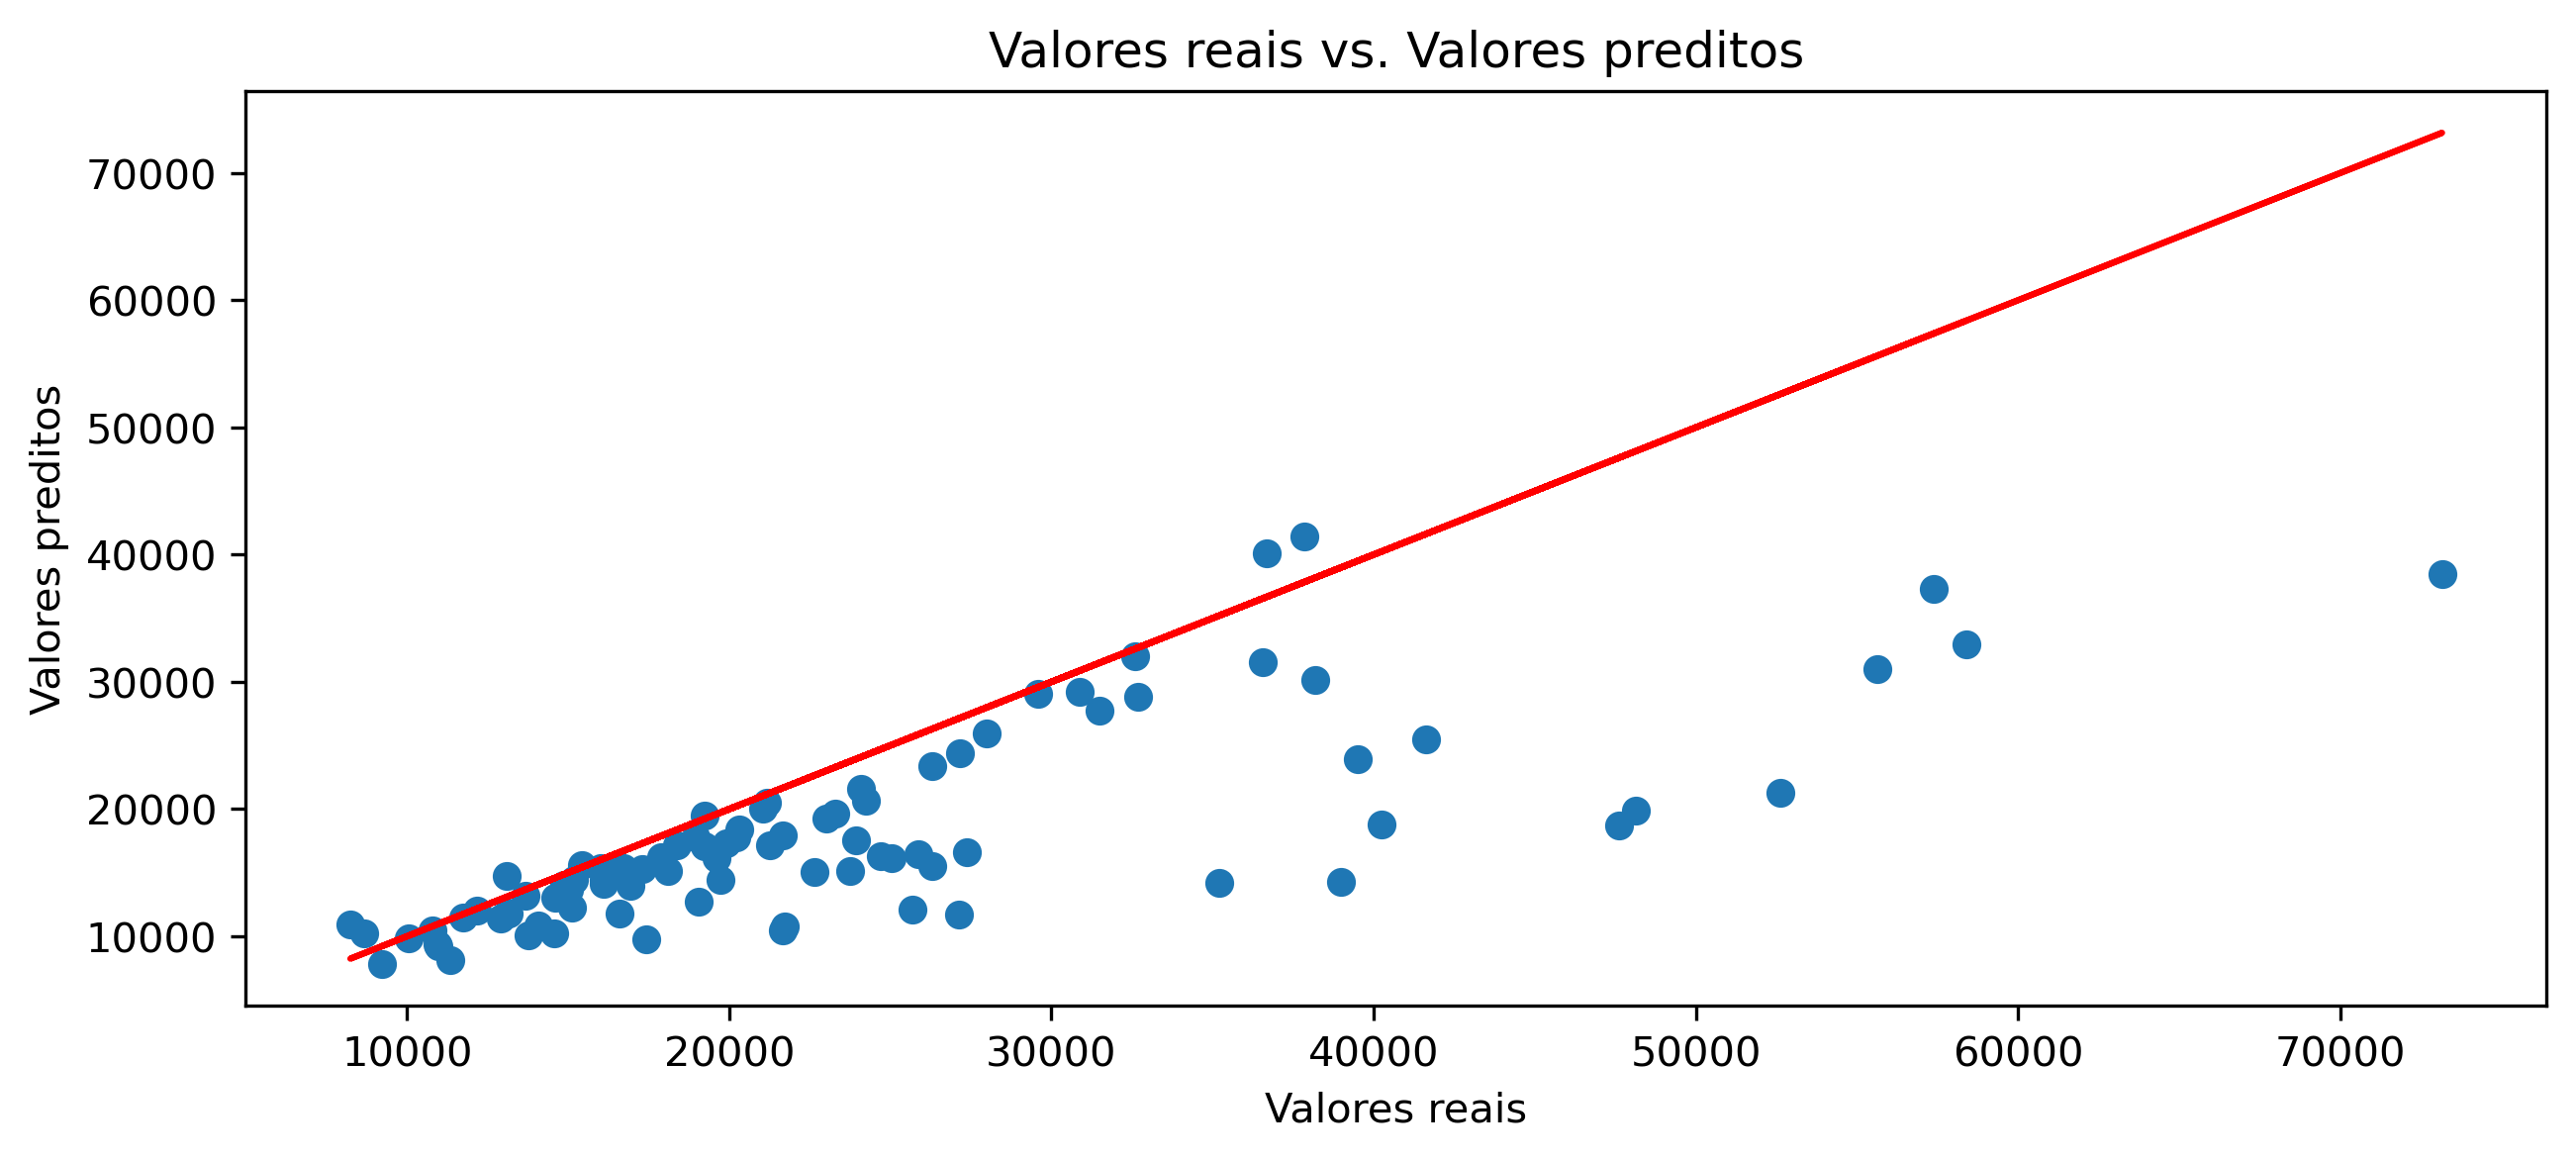

In [131]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(10, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()

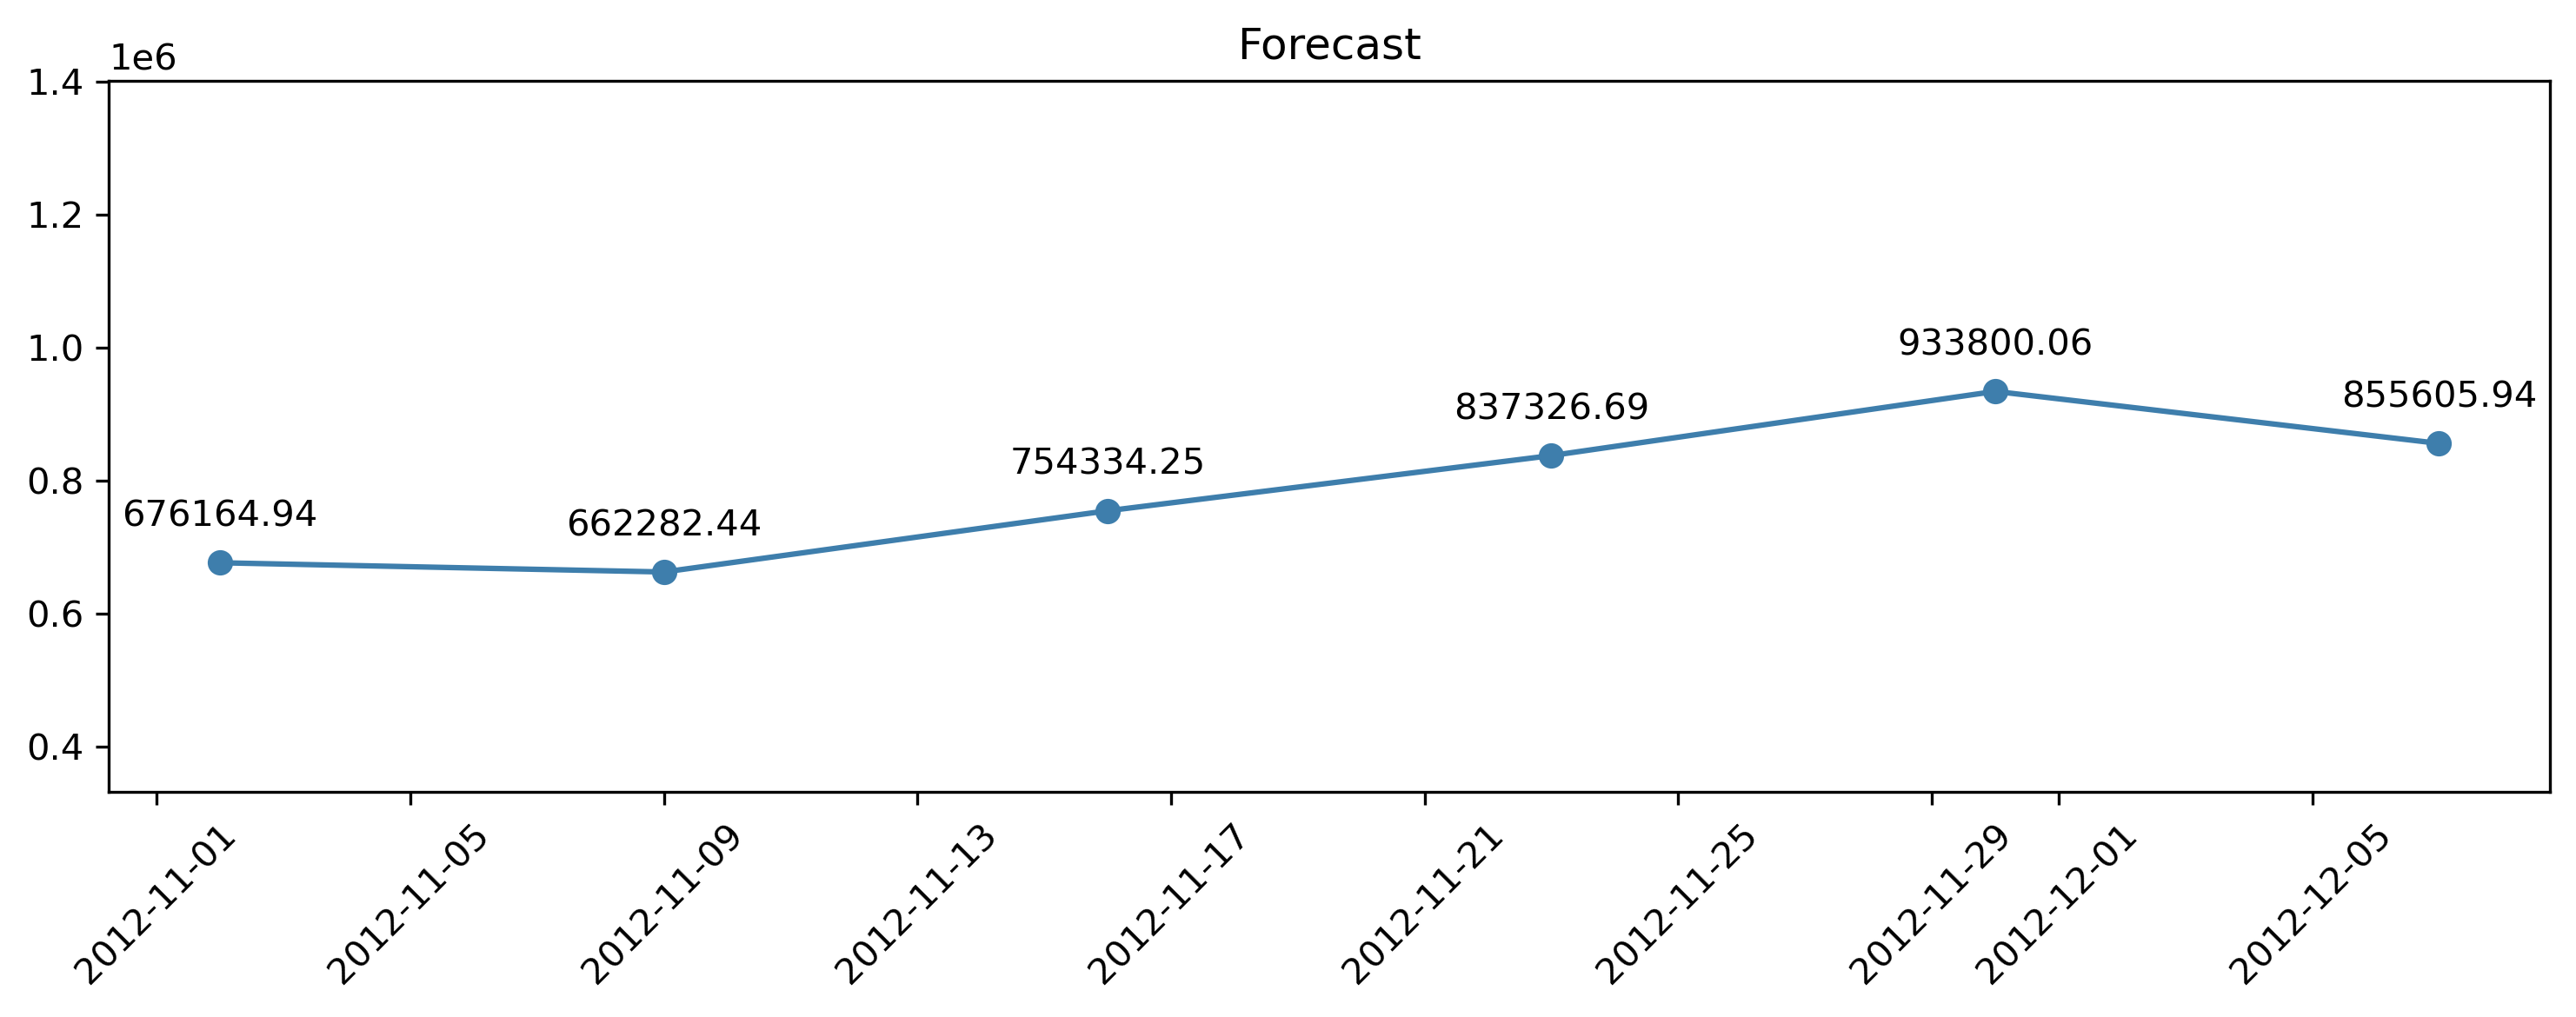

In [132]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Previsão para valores de datas futuras
--------------------------------------------------------------------------------------------------------------------
'''

# Adicionar a coluna de Weekly_Sales no dataset de teste para ficar igual ao de treino
# O Range de previsão pré definido por mim foram 6 semanas do futuro, sendo de 02/11/2012 até 07/12/2012
data_inicio = '2012-11-02'
data_fim = '2012-12-07'
test = test[(test['Date'] >= data_inicio) & (test['Date'] <= data_fim)]
test['Weekly_Sales'] = np.nan

'''
--------------------------------------------------------------------------------------------------------------------
-------- Transformando o dataset de test (futuro) no mesmo padrão do utilizado no modelo
--------------------------------------------------------------------------------------------------------------------
'''

# Juntando os dois dataframes para aplicar todas as alterações feitas lá em cima, para 
# deixá-lo no mesmo padrão do utilizado no treino do modelo e conseguirmos prever os valores que não temos
df_combined = pd.concat([test, train])

# Juntando as colunas de features dos arquivos Stores e Features
test_merge = pd.merge(df_combined, stores, on='Store', how='left')
test_merge = pd.merge(test_merge, features, on=['Store', 'Date'], how='left')

# Index
test_merge['Date'] = pd.to_datetime(test_merge['Date'])
test_merge = test_merge.sort_values(by=['Store', 'Date'])
test_merge = test_merge.set_index('Date')

# Transformando coluna string em int
transf = {}

for i, valor in enumerate(test_merge['Type'].unique()):
    transf[valor] = i

test_merge['Type'] = test_merge['Type'].map(transf)

dept1_forecast = test_merge[test_merge['Dept'] == 1]
dept1_forecast = dept1_forecast.drop(columns='Dept')

# Criando as lags
for i in range(6, 13):
    dept1_forecast[f'lag{i}'] = dept1_forecast.groupby('Store')['Weekly_Sales'].shift(i)

# Separando somente as colunas necessários igualmente utilizadas para treinar o modelo
dept1_forecast = dept1_forecast[colunas].drop(columns='Weekly_Sales')

'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando o modelo para datas que não temos os valores de vendas
--------------------------------------------------------------------------------------------------------------------
'''

X_forecast = dept1_forecast[dept1_forecast.index >= '2012-11-02']

forecast = model.predict(X_forecast)

df_forecast = pd.DataFrame({'Date': X_forecast.index, 'Store': X_forecast['Store'], 'Forecast': forecast})
df_forecast.reset_index(drop=True, inplace=True)
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

forecast_groupby_date = df_forecast.groupby('Date')['Forecast'].sum().reset_index()
forecast_groupby_date_store = df_forecast.groupby(['Store', 'Date'])['Forecast'].sum().reset_index()

# Gráfico de tempo com o somatório do forecast de todas as lojas do dept = 1 pelas próximas 6 semanas
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(forecast_groupby_date['Date'], forecast_groupby_date['Forecast'], marker='o', linestyle='-', color='#3e7eac')

for x, y in zip(forecast_groupby_date['Date'], forecast_groupby_date['Forecast']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Forecast')
plt.ylim(bottom=forecast_groupby_date['Forecast'].min() * 0.5)
plt.ylim(top=forecast_groupby_date['Forecast'].max() * 1.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hiperparemetros

In [133]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando Optuna para testar hiperparâmetros
--------------------------------------------------------------------------------------------------------------------
'''

import optuna

def objective(trial):
    
    # Espaço de hiperparâmetros para tunar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1),
    }
    
    # Modelo
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
    
    # Predição e cálculo do RMSE
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

# Criando o estudo
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Melhores parâmetros
print('Best trial:', study.best_trial.params)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando os hipérparâmetros encontrados
--------------------------------------------------------------------------------------------------------------------
'''

model = xgb.XGBRegressor(**study.best_trial.params)
model.fit(X_train, y_train)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Encontrar os erros desse novo modelo e juntar com os anteriores em results_df
--------------------------------------------------------------------------------------------------------------------
'''
predictions = model.predict(X_test)

error = np.sum(predictions - y_test).round(2)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.concat([results_df, pd.DataFrame({'Teste': ['XGBRegressor Optuna'],
                                                    'Erro Total': [error],
                                                    'RMSE': [rmse],
                                                    'MAE': [mae],
                                                    'MAPE (%)': [mape]
                                                      })])

# Exibir o DataFrame
results_df

[I 2024-04-19 20:34:21,730] A new study created in memory with name: no-name-959df391-7935-4915-8be5-ef8159f6f2d8


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


[I 2024-04-19 20:34:22,060] Trial 0 finished with value: 10334.370259925914 and parameters: {'n_estimators': 191, 'max_depth': 8, 'learning_rate': 0.12048448724504365, 'subsample': 0.82647100850184, 'colsample_bytree': 0.9656082571701023, 'reg_alpha': 0.00037576646694804233, 'reg_lambda': 0.040275363360262585}. Best is trial 0 with value: 10334.370259925914.
[I 2024-04-19 20:34:23,043] Trial 1 finished with value: 10355.123533201151 and parameters: {'n_estimators': 168, 'max_depth': 18, 'learning_rate': 0.06896044401318883, 'subsample': 0.8448338046254142, 'colsample_bytree': 0.5683699687190791, 'reg_alpha': 0.00017916201192602816, 'reg_lambda': 6.657925604691814}. Best is trial 0 with value: 10334.370259925914.
[I 2024-04-19 20:34:23,264] Trial 2 finished with value: 10293.447602589102 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.05466744672256181, 'subsample': 0.7678447761693064, 'colsample_bytree': 0.5137377376360182, 'reg_alpha': 0.0038968796373054595, '

Best trial: {'n_estimators': 201, 'max_depth': 9, 'learning_rate': 0.1168653718062149, 'subsample': 0.9544644246654876, 'colsample_bytree': 0.7713920625625367, 'reg_alpha': 0.0009107342447271688, 'reg_lambda': 0.10116364625770144}


,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default,-543076.87,10255.415900,6402.467963,21.751738
0,XGBRegressor Optuna,-500780.46,9949.516255,6070.576636,20.474974


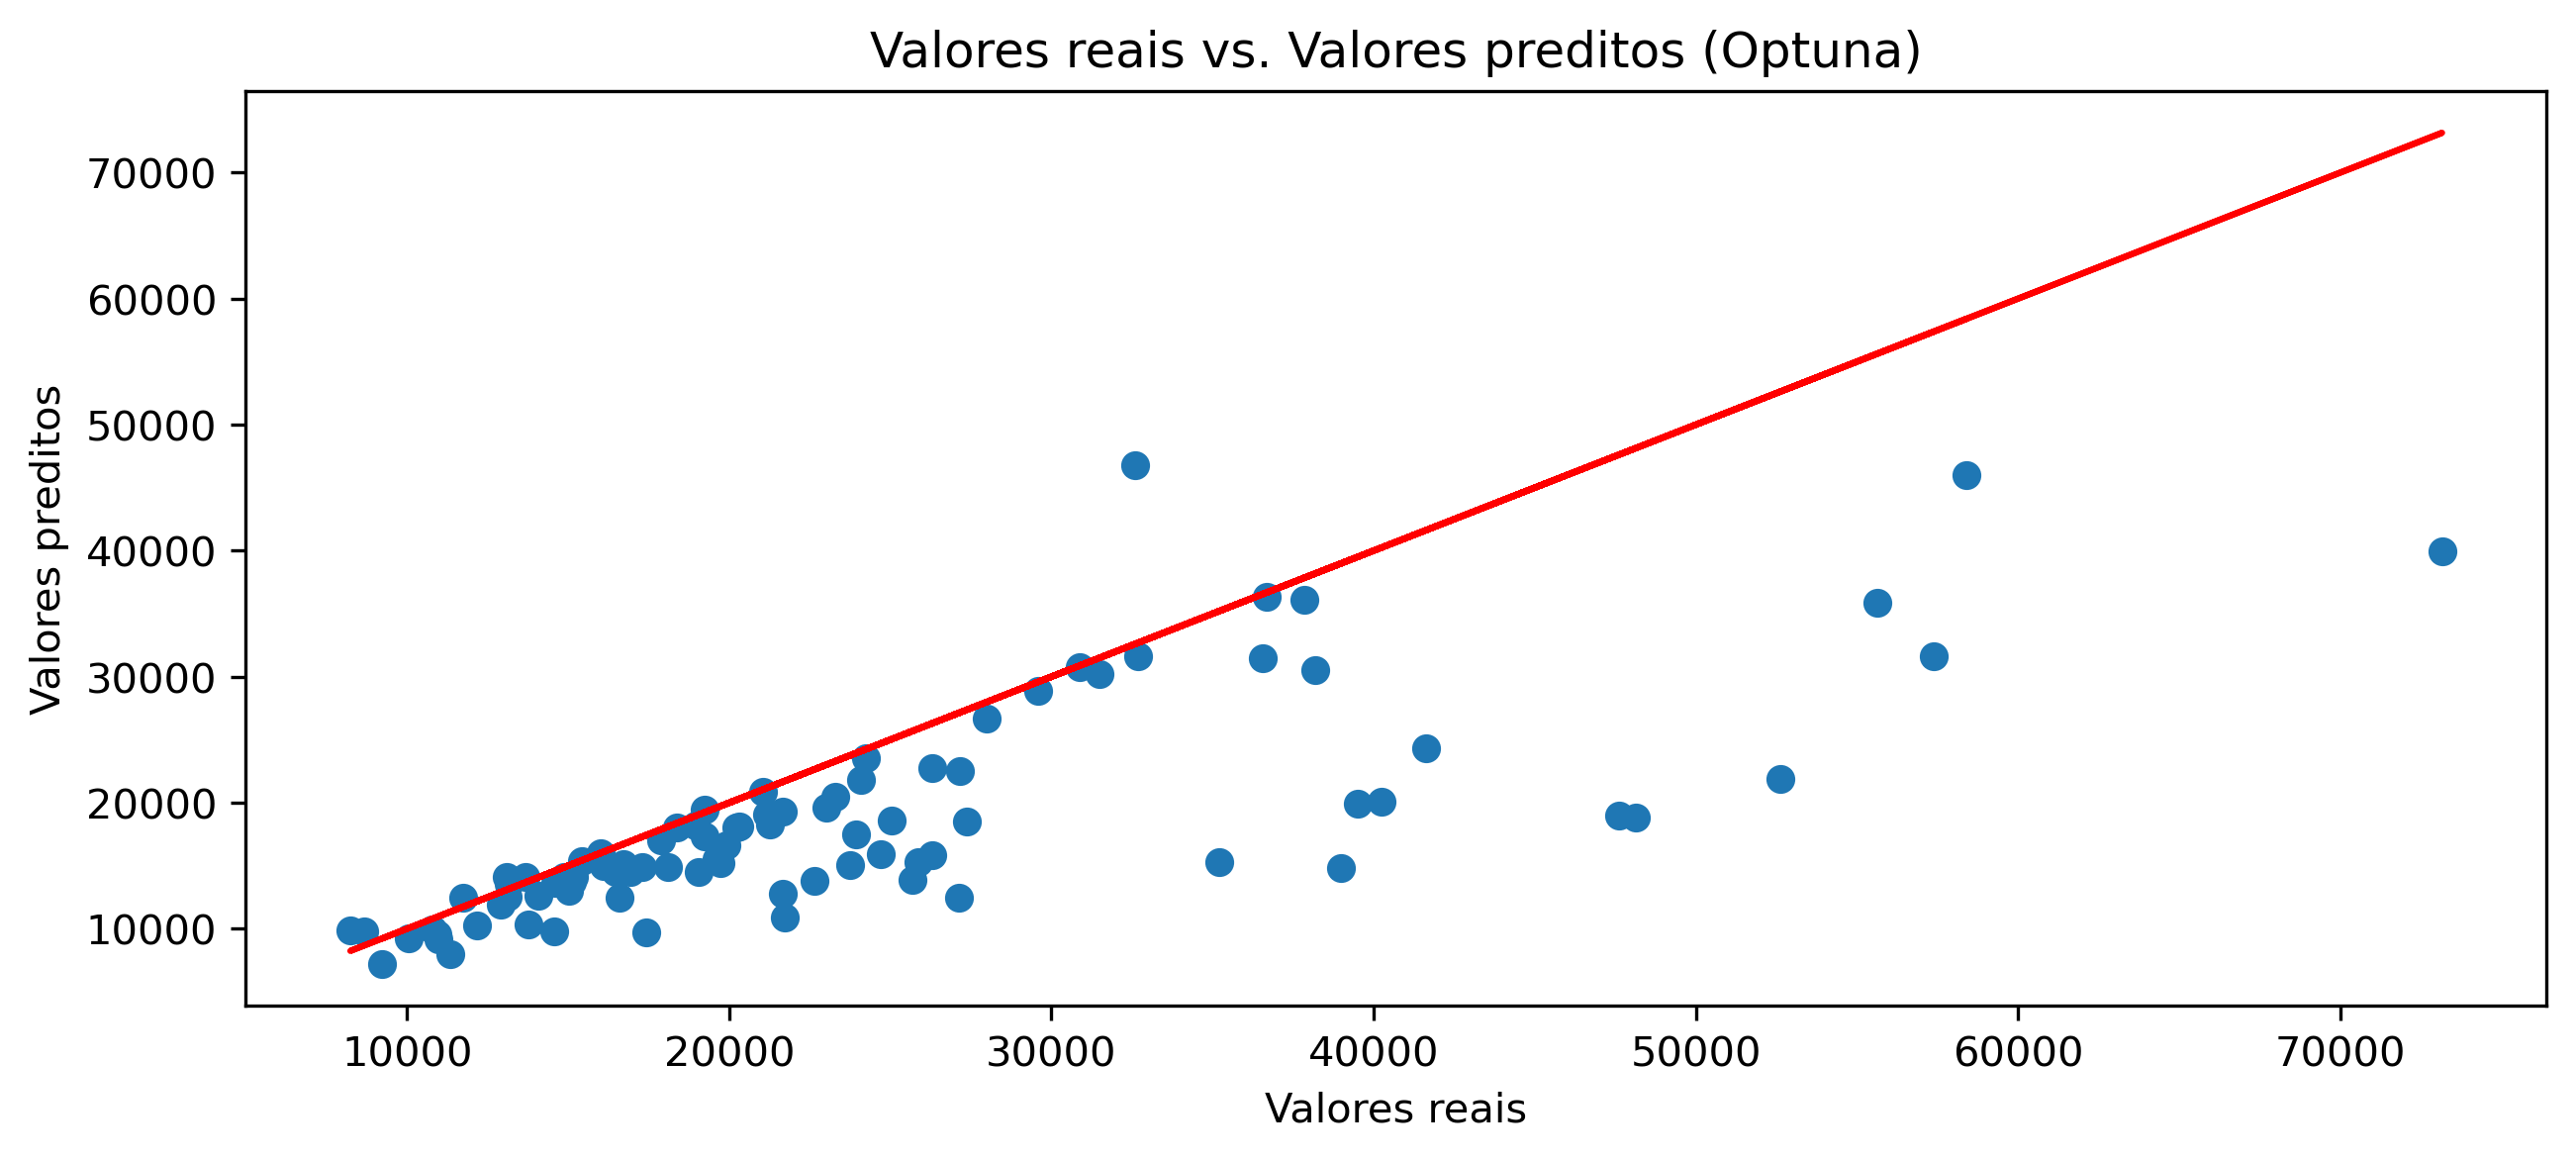

In [134]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(10, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos (Optuna)')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()

In [135]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicar grid search para encontrar os melhores hiperparâmetros
--------------------------------------------------------------------------------------------------------------------
'''

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_alpha': [1e-4, 1e-2, 1e0],
    'reg_lambda': [1e-4, 1e-2, 1e0]
}

model = xgb.XGBRegressor(verbosity=1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhores parâmetros
print('Best params:', grid_search.best_params_)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Aplicando os hipérparâmetros encontrados
--------------------------------------------------------------------------------------------------------------------
'''

model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)

'''
--------------------------------------------------------------------------------------------------------------------
-------- Encontrar os erros desse novo modelo e juntar com os anteriores em results_df
--------------------------------------------------------------------------------------------------------------------
'''
predictions = model.predict(X_test)

error = np.sum(predictions - y_test).round(2)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Criar DataFrame com os resultados
results_df = pd.concat([results_df, pd.DataFrame({'Teste': ['XGBRegressor GridSearch'],
                                                    'Erro Total': [error],
                                                    'RMSE': [rmse],
                                                    'MAE': [mae],
                                                    'MAPE (%)': [mape]
                                                      })])

# Exibir o DataFrame
results_df

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001, reg_lambda=0.0001, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0.0001

,Teste,Erro Total,RMSE,MAE,MAPE (%)
0,XGBRegressor Default,-543076.87,10255.415900,6402.467963,21.751738
0,XGBRegressor Optuna,-500780.46,9949.516255,6070.576636,20.474974
0,XGBRegressor GridSearch,-532674.19,10355.063773,6364.465101,21.031952


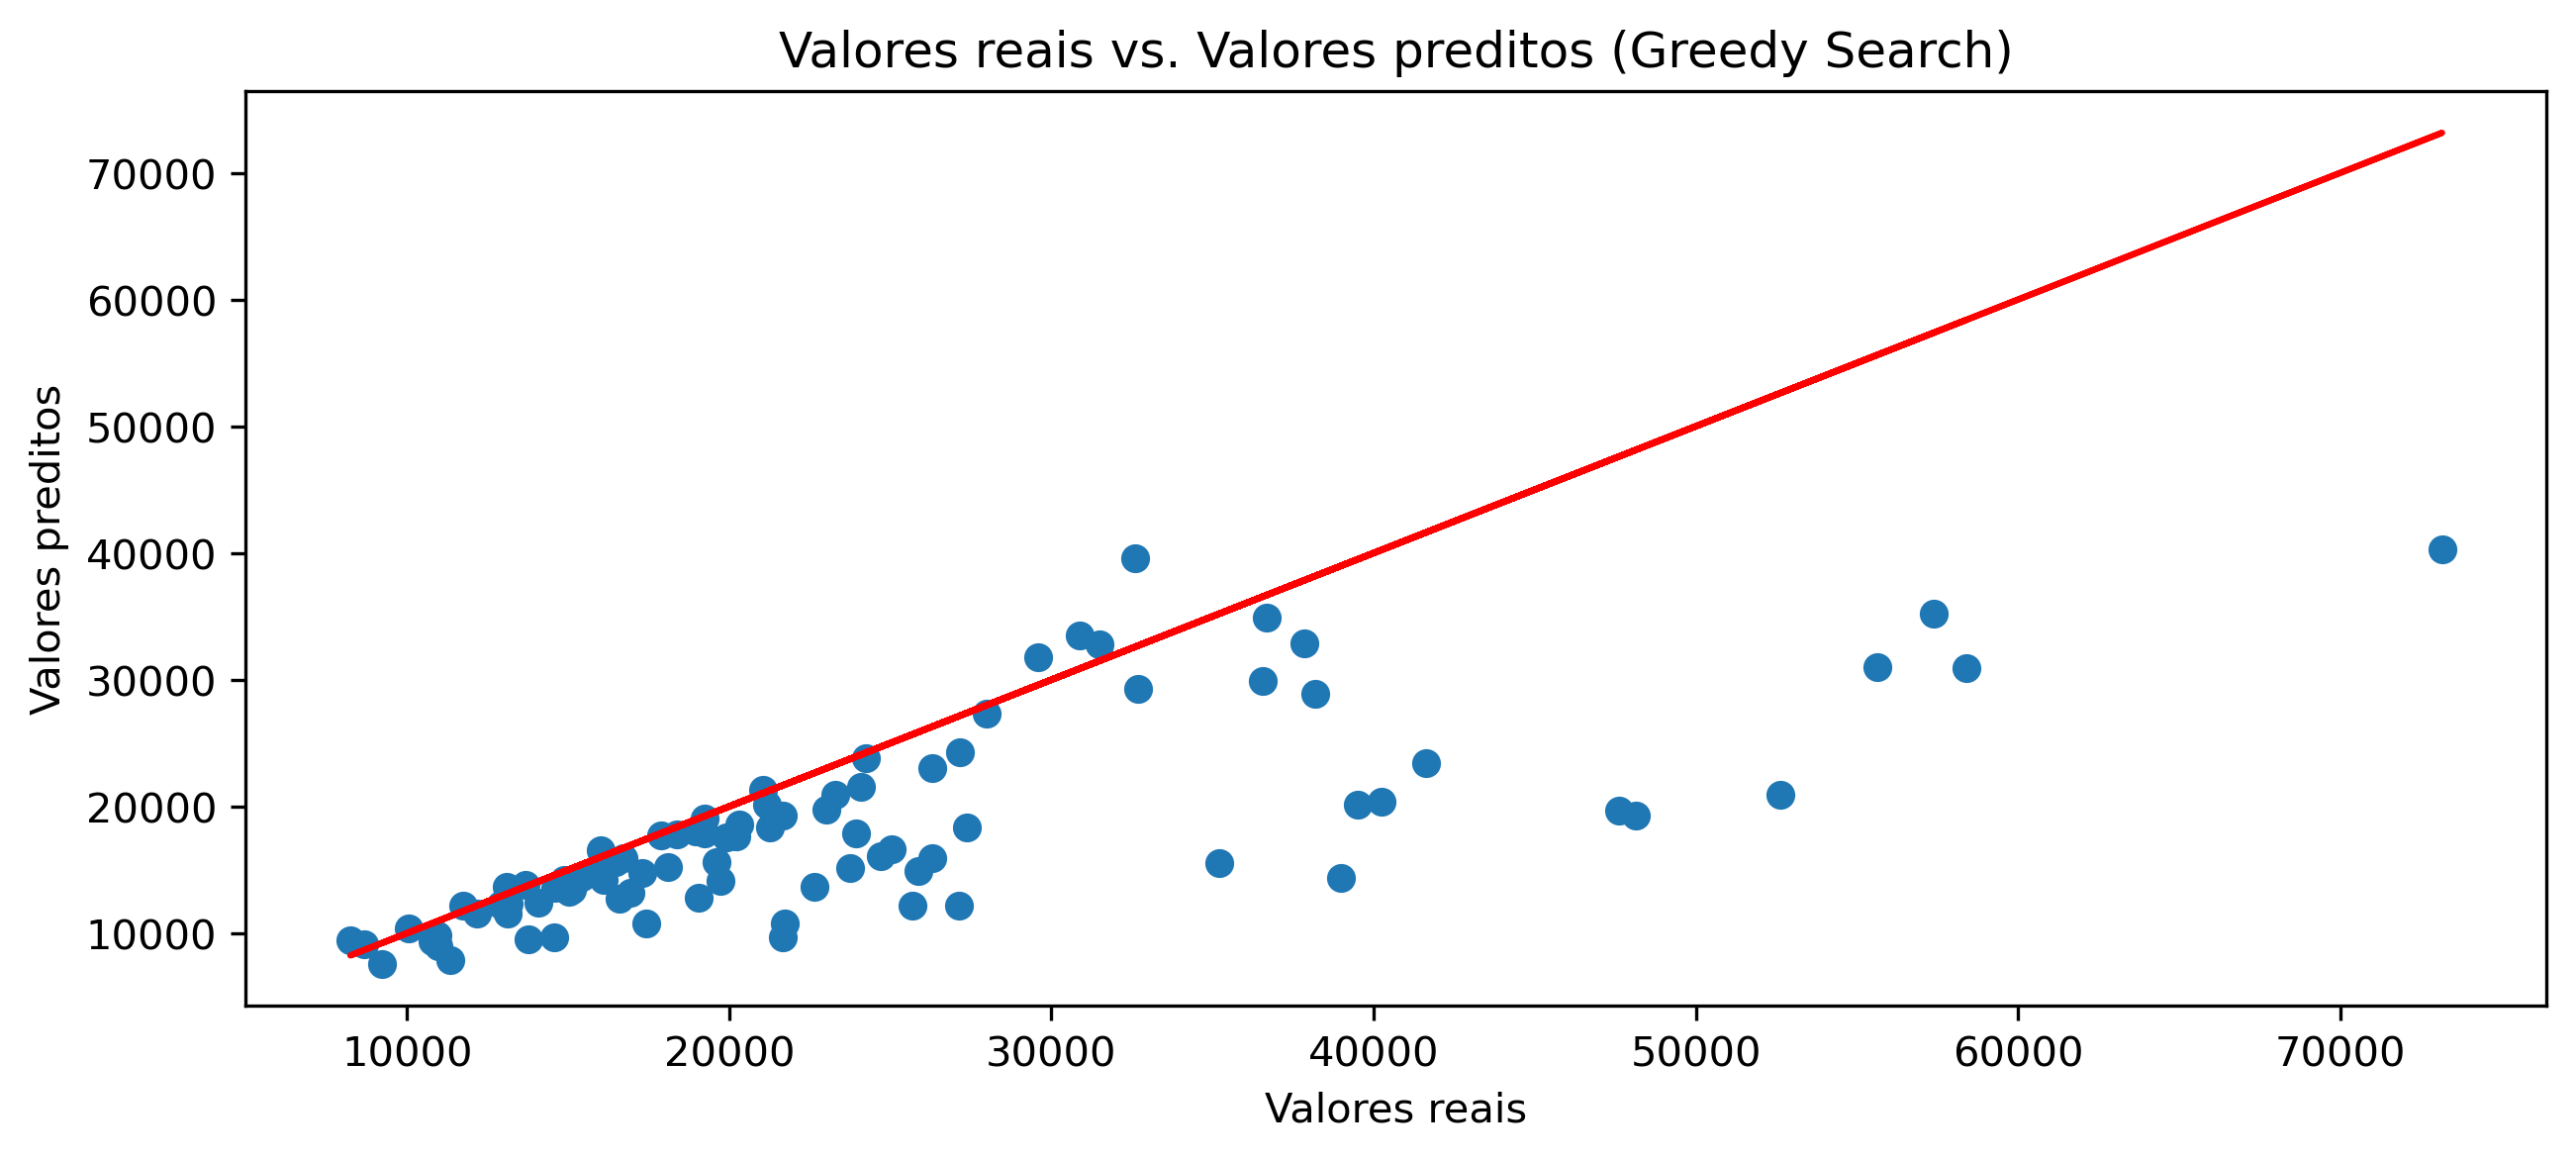

In [136]:
'''
--------------------------------------------------------------------------------------------------------------------
-------- Dispersão dos valores reais e preditos
--------------------------------------------------------------------------------------------------------------------
'''

plt.figure(figsize=(10, 4), dpi=300)
plt.scatter(y_test, predictions)
plt.title('Valores reais vs. Valores preditos (Greedy Search)')
plt.xlabel('Valores reais')
plt.ylabel('Valores preditos')
plt.plot(y_test, y_test, color='red')
plt.show()